# Bayesian Belief Network for Mission assurance/Mission Requirements

# Install dependencies 
1. `pybbn`
2. `networkx`
3. `scipy`
4. `pandas`
5. `matplotlib`
6. `numpy`

In [6]:
!pip install pybbn networkx scipy pandas matplotlib numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 7.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
ERROR: Cannot uninstall numpy 1.23.5, RECORD file not found. You might be able to recover from this via: 'pip install --force-reinstall --no-deps numpy==1.23.5'.


In [4]:
"""
Uncomment the %matplotlib lines if you want to interact with the widget in the jupyter notebook
Due to matplotlib params, the graph may overlap with sliders. In such cases, run it as a .py file and you can adjust the graph area.
"""

# %matplotlib inline
# %matplotlib widget

import random
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
np.seterr(invalid='ignore')

import pandas as pd
pd.set_option('display.max_rows', None)

import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

import pybbn
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController
from pybbn.sampling.sampling import LogicSampler

from scipy.stats import binom
from utils_sys import Printer

# Binomial Distribution function: 
Given number of experiments to be performed and the prior probability of success, returns the list of probabilities of successes for k trials out of total n runs.

In [5]:


def getBinomProb(total_exp_runs,p):
    """Given number of experiments to be performed and the prior probability of success, returns the list of probabilities of successes for k trials out of total n runs

    Args:
        total_exp_runs (_type_): number of experiments
        p (_type_): probability of success

    Returns:
        _type_: list of probabilities of success for k out of n runs
    """
    return list(binom.pmf(list(range(total_exp_runs + 1)),total_exp_runs, p))

def getCDFBinomProb(total_exp_runs,p):
    """Given number of experiments to be performed and the prior probability of success, returns the list of cumulative probabilities of successes for k trials out of total n runs

    Args:
        total_exp_runs (_type_): number of experiments
        p (_type_): probability of success

    Returns:
        _type_: list of cumulative probabilities of success up till k out of n runs
    """
    return list(binom.cdf(list(range(total_exp_runs + 1)),total_exp_runs, p))



# pybbn Functions

In [ ]:
def evidence(join_tree,ev, nod, cat, val):
    """Sets the evidence of a particular node by its name, state and probability value

    Args:
        join_tree (_type_): Bayesian Belief Network
        ev (_type_): name of evidence
        nod (_type_): Node name where you need to plug the evidence
        cat (_type_): Which state should the evidence be incorporated into (e.g: True or False state if node has 2 states true/false)
        val (_type_): Probability value of evidence (set to 1 as it is evidence)
    """
    ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name(nod)) \
    .with_evidence(cat, val) \
    .build()
    join_tree.set_observation(ev)

def resetEvidence(join_tree):
    """Resets entrie evidence of the BBN to their predefined values

    Args:
        join_tree (_type_): clears evidence from BBN
    """
    join_tree.unobserve_all()

def print_probs(join_tree):
    """Printing Posterior Probabilities

    Args:
        join_tree (_type_): Prints out all posterior probabilities of all nodes in the BBN
    """
    for node in join_tree.get_bbn_nodes():
        potential = join_tree.get_bbn_potential(node)
        print("Node:", node.to_dict())
        print("Values:")
        print(potential)
        print('----------------')
    print("="*90)

def print_probs_node(join_tree,id):
    """Fetches posterior probabilities of particular node by using its ID

    Args:
        join_tree (_type_): BBN tree
        id (_type_): ID assigned to node during building BBN

    Returns:
        _type_: Pandas Dataframe
    """
    for node in join_tree.get_bbn_nodes():
        if (node.to_dict()['variable']['id']==id):
            Printer.green("Node:",node.variable.name)
            potential = join_tree.get_bbn_potential(node)
            df = potential_to_df(join_tree.get_bbn_potential(node))
            # display(df)
            Printer.yellow(df)
            return df

def potential_to_df(p):
    """Dataframe of a node with its states and their probability values

    Args:
        p (_type_): Potential values from BBN

    Returns:
        _type_: Pandas Dataframe
    """
    data = []
    for pe in p.entries:
        try:
            v = pe.entries.values()[0]
        except:
            v = list(pe.entries.values())[0]
        p = pe.value
        t = (v, p)
        data.append(t)
    return pd.DataFrame(data, columns=['val', 'p'])

def potentials_to_dfs(join_tree):
    """Returns all nodes and their state values as a list of dataframes

    Args:
        join_tree (_type_): BBN

    Returns:
        _type_: Pandas Dataframe
    """
    data = []
    for node in join_tree.get_bbn_nodes():
        name = node.variable.name
        df = potential_to_df(join_tree.get_bbn_potential(node))
        t = (name, df)
        data.append(t)
    return data

def drawBBN(bbn):
    """Prints a structure of the BBN suing networkx library

    Args:
        bbn (_type_): Built BBN 
    """
    n, d = bbn.to_nx_graph()
    pos = nx.spring_layout(n)
    nx.draw_spring(n,with_labels=True,labels=d)
    ax = plt.gca()
    plt.show()

In [1]:



def BBN_mission(n_runs,prob_no_collision,prob_pose_within_threshold,p_nav,
                threshold_num_collision,threshold_num_nav,threshold_num_pose_within_threshold):
    """_summary_

    Args:
        n_runs (_type_): number of runs
        prob_no_collision (_type_): probability of no collision
        prob_pose_within_threshold (_type_): probability of pose being within destination pose region/threshold
        p_nav (_type_): probability of navigating over correct terrain
        threshold_num_collision (_type_): threshold limit of collisions allowed
        threshold_num_nav (_type_): threshold limit of unnavigable terrain allowed
        threshold_num_pose_within_threshold (_type_): threshold limit of number of times pose should be within threshold regions

    Returns:
        _type_: pandas dataframe and the BBN built
    """

    simulation_data = []

    prob_no_collision_lst = getBinomProb(n_runs,1-prob_no_collision)
    Printer.blue(prob_no_collision_lst)
    prob_no_collision_cpt = pd.DataFrame({"success":prob_no_collision_lst})
    idxlist = prob_no_collision_cpt.index.tolist()
    prob_no_collision_cpt = prob_no_collision_cpt.set_index([pd.Index(["n"+str(idx) for idx in idxlist])])

    # display(prob_no_collision_cpt)

    mission_no_collision_keys = []
    mission_no_collision_values = []
    
    for i in range(n_runs+1):
        mission_no_collision_keys.append(str(i))
        # if threshold is small, then more collisions are not allowed, higher threshold means we are okay if the robot collides
        if i > threshold_num_collision:
            # false state
            mission_no_collision_values.append([0,1])
        else:
            # true state
            mission_no_collision_values.append([1,0])

    prob_collision_lst = dict(zip(mission_no_collision_keys, mission_no_collision_values))
    prob_collision = pd.DataFrame(prob_collision_lst)
    prob_collision["States"] = ['True','False']
    prob_collision.set_index("States",inplace=True)

    # display(prob_collision)


    prob_navterrain_better_lst = getBinomProb(n_runs,p_nav)
    navterrain_better = pd.DataFrame({"success":prob_navterrain_better_lst})
    idxlist = navterrain_better.index.tolist()
    prob_navterrain_better = navterrain_better.set_index([pd.Index(["n"+str(idx) for idx in idxlist])])

    # display(prob_navterrain_better)

    nav_keys = []
    nav_vals = []
    for i in range(n_runs+1):
        nav_keys.append(str(i))
        # if threshold is small, then more collisions are allowed, higher threshold means we would like the robot to not traverse over bad terrain
        if i >= threshold_num_nav:
            nav_vals.append([1,0])
        else:
            nav_vals.append([0,1])

    nav_dict = dict(zip(nav_keys, nav_vals))
    all_waypoints_cpt = pd.DataFrame(nav_dict)
    all_waypoints_cpt["States"] = ['True','False']
    all_waypoints_cpt.set_index("States",inplace=True)
    # display(all_waypoints_cpt)



    prob_pose_within_threshold_lst = getBinomProb(n_runs,prob_pose_within_threshold)
    prob_pose_within_threshold_cpt = pd.DataFrame({"success":prob_pose_within_threshold_lst})
    idxlist = prob_pose_within_threshold_cpt.index.tolist()
    prob_pose_within_threshold_cpt = prob_pose_within_threshold_cpt.set_index([pd.Index(["n"+str(idx) for idx in idxlist])])
    # display(prob_pose_within_threshold_cpt)

    mission_pose_within_threshold_keys = []
    mission_pose_within_threshold_values = []
    for i in range(n_runs+1):
        mission_pose_within_threshold_keys.append(str(i))
        if i >= threshold_num_pose_within_threshold:
            mission_pose_within_threshold_values.append([1,0])
        else:
            mission_pose_within_threshold_values.append([0,1])

    prob_pose_lst = dict(zip(mission_pose_within_threshold_keys, mission_pose_within_threshold_values))
    prob_pose = pd.DataFrame(prob_pose_lst)
    prob_pose["States"] = ['True','False']
    prob_pose.set_index("States",inplace=True)


    # define nodes, states, cpt
    mission_success = BbnNode(Variable(0, 'Meeting requirements',
                        ["True","False"]),
                        [1,0, #ttt
                        0,1,  #ttf
                        0,1,  #tft
                        0,1,  #ftt
                        0,1,  #tff
                        0,1,  #ftf
                        0,1,  #fft
                        0,1]) #fff


    mission_all_waypoints = BbnNode(Variable(1, 'Robot reached all waypoints by traversing atleast '+str(threshold_num_nav)+' times on navigable terrain',
                                            all_waypoints_cpt.index.values.tolist()),
                                            np.ndarray.flatten(all_waypoints_cpt.transpose().values).tolist())



    mission_times_navigable_terrain = BbnNode(Variable(2, "Number of times navigable terrain traversed over unwanted terrain",
                                                [str(i) for i in range(n_runs+1)]),
                                                prob_navterrain_better_lst)


    mission_no_collision = BbnNode(Variable(3, 'Robot collided at max '+str(threshold_num_collision),
                                            prob_collision.index.values.tolist()),
                                            np.ndarray.flatten(prob_collision.transpose().values).tolist())


    mission_times_collision = BbnNode(Variable(4, 'Number of times robot collided',
                        [str(i) for i in range(n_runs+1)]),
                        prob_no_collision_lst)

    mission_pose_in_threshold = BbnNode(Variable(5, 'Robot pose within threshold atleast '+str(threshold_num_pose_within_threshold),
                                            prob_pose.index.values.tolist()),
                                            np.ndarray.flatten(prob_pose.transpose().values).tolist())

    mission_times_pose_within_threshold = BbnNode(Variable(6, 'Number of times robot pose within threshold',
                        [str(i) for i in range(n_runs+1)]),
                        prob_pose_within_threshold_lst)

    """
    Building the BBN:
        - add nodes in any order
        - ensure that the connections are bottom-up
        - pybbn creates BBN as a bottom-up graph and not top-down
    """

    bbn = Bbn() \
        .add_node(mission_success) \
        .add_node(mission_all_waypoints) \
        .add_node(mission_no_collision) \
        .add_node(mission_pose_in_threshold) \
        .add_node(mission_times_navigable_terrain) \
        .add_node(mission_times_collision) \
        .add_node(mission_times_pose_within_threshold) \
        .add_edge(Edge(mission_times_navigable_terrain, mission_all_waypoints, EdgeType.DIRECTED)) \
        .add_edge(Edge(mission_all_waypoints, mission_success, EdgeType.DIRECTED)) \
        .add_edge(Edge(mission_times_collision, mission_no_collision, EdgeType.DIRECTED)) \
        .add_edge(Edge(mission_no_collision, mission_success, EdgeType.DIRECTED)) \
        .add_edge(Edge(mission_times_pose_within_threshold, mission_pose_in_threshold, EdgeType.DIRECTED)) \
        .add_edge(Edge(mission_pose_in_threshold, mission_success, EdgeType.DIRECTED))

    """
    Creates a tree structure used for inference
    """

    join_tree = InferenceController.apply(bbn)


    """
    Get all posterior probabilities with the given priors
    """

    mission_df = print_probs_node(join_tree,0)
    mission_df.p = mission_df.p.round(4)

    waypoint_with_terrain_df = print_probs_node(join_tree,1)
    waypoint_with_terrain_df.p = waypoint_with_terrain_df.p.round(4)

    nwaypoint_with_terrain_df = print_probs_node(join_tree,2)
    nwaypoint_with_terrain_df.p = waypoint_with_terrain_df.p.round(4)

    collision_df = print_probs_node(join_tree,3)
    collision_df.p = collision_df.p.round(4)

    ncollision_df = print_probs_node(join_tree,4)
    ncollision_df.p = collision_df.p.round(4)

    pose_df = print_probs_node(join_tree,5)
    pose_df.p = pose_df.p.round(4)

    npose_df = print_probs_node(join_tree,6)
    npose_df.p = pose_df.p.round(4)
    
    

    data = [n_runs,prob_no_collision,prob_pose_within_threshold,p_nav,
            threshold_num_collision,threshold_num_nav,threshold_num_pose_within_threshold,
            mission_df.p[0],mission_df.p[1],
            waypoint_with_terrain_df.p[0],waypoint_with_terrain_df.p[1],
            collision_df.p[0],collision_df.p[1],
            pose_df.p[0],pose_df.p[1]]
    # Printer.orange(data)
    simulation_data.append(data)


    df = pd.DataFrame(simulation_data, columns = ["n_runs","prob_no_collision","prob_pose_within_threshold","p_nav",
                    "threshold_num_collision","threshold_num_nav","threshold_num_pose_within_threshold",
                    "mission_true","mission_false",
                    "waypoint_true","waypoint_false",
                    "collision_true","collision_false",
                    "pose_true","pose_false",
                    ])

    Printer.cyan(f"I want atleast {threshold_num_nav}/{n_runs} times to be on navigable terrain!")
    Printer.cyan(f"I want atleast {threshold_num_pose_within_threshold}/{n_runs} times to be within accepted limits of goal region!")
    Printer.cyan(f"I am okay with {threshold_num_collision}/{n_runs} instances of collision incidents!")
    Printer.red("="*50)
    
    """
    All posterior data from a single set of priors
    """

    return df,bbn


 [1.0, 0.0, 0.0, 0.0]
 Node: Meeting requirements
      val    p
0   True  1.0
1  False  0.0
 Node: Robot reached all waypoints by traversing atleast 0 times on navigable terrain
      val    p
0   True  1.0
1  False  0.0
 Node: Number of times navigable terrain traversed over unwanted terrain
   val    p
0   0  0.0
1   1  0.0
2   2  0.0
3   3  1.0
 Node: Robot collided at max 0
      val    p
0   True  1.0
1  False  0.0
 Node: Number of times robot collided
   val    p
0   0  1.0
1   1  0.0
2   2  0.0
3   3  0.0
 Node: Robot pose within threshold atleast 0
      val    p
0   True  1.0
1  False  0.0
 Node: Number of times robot pose within threshold
   val    p
0   0  0.0
1   1  0.0
2   2  0.0
3   3  1.0
 I want atleast 0/3 times to be on navigable terrain!
 I want atleast 0/3 times to be within accepted limits of goal region!
 I am okay with 0/3 instances of collision incidents!


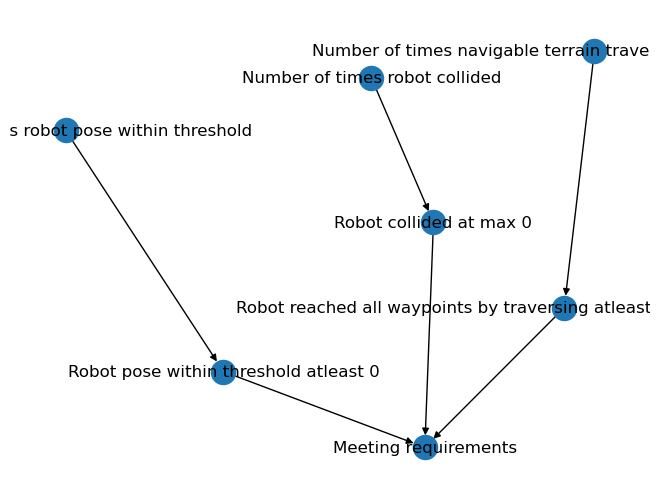

In [2]:
# example data
df,bbn = BBN_mission(3,1,1,1,0,0,0)
drawBBN(bbn)

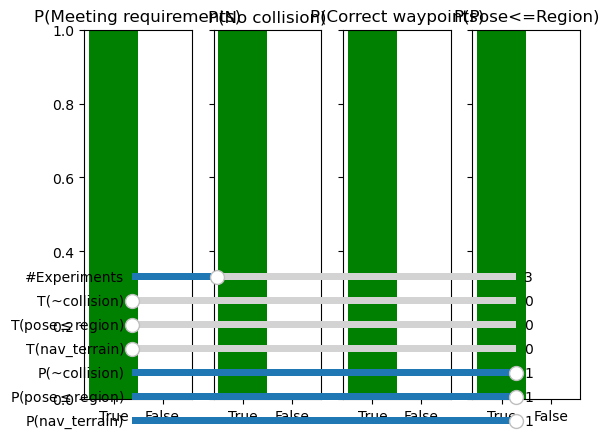

In [3]:

"""
Plotting everything wiht sliders as inputs: 
"""

bar_width = 0.35
x_pos = np.arange(1)*2

fig,ax = plt.subplots(1,4,sharey=True)

mission_t = df.mission_true.values.tolist()[0]
mission_f = df.mission_false.values.tolist()[0]

collision_t = df.collision_true.values.tolist()[0]
collision_f = df.collision_false.values.tolist()[0]

waypoint_t = df.waypoint_true.values.tolist()[0]
waypoint_f = df.waypoint_false.values.tolist()[0]

pose_t = df.pose_true.values.tolist()[0]
pose_f = df.pose_false.values.tolist()[0]

plt.subplot(141)
plt.ylim(0, 1)
plt.title("P(Meeting requirements)")
mission_true = plt.bar(x_pos, mission_t, bar_width, color='g', label='False')
mission_false = plt.bar(x_pos + bar_width, mission_f, bar_width, color='r', label='False')
plt.xticks([0, bar_width], ['True', 'False'])

plt.subplot(142)
plt.ylim(0, 1)
plt.title("P(No collision)")
collision_true = plt.bar(x_pos, collision_t, bar_width, color='g', label='False')
collision_false = plt.bar(x_pos + bar_width, collision_f, bar_width, color='r', label='False')
plt.xticks([0, bar_width], ['True', 'False'])

plt.subplot(143)
plt.ylim(0, 1)
plt.title("P(Correct waypoints)")
waypoint_true = plt.bar(x_pos, waypoint_t, bar_width, color='g', label='False')
waypoint_false = plt.bar(x_pos + bar_width, waypoint_f, bar_width, color='r', label='False')
plt.xticks([0, bar_width], ['True', 'False'])

plt.subplot(144)
plt.ylim(0, 1)
plt.title("P(Pose<=Region)")
pose_true = plt.bar(x_pos, pose_t, bar_width, color='g', label='False')
pose_false = plt.bar(x_pos + bar_width, pose_f, bar_width, color='r', label='False')
plt.xticks([0, bar_width], ['True', 'False'])

# Create the sliders
slider_ax1 = plt.axes([0.2, 0.35, 0.6, 0.03])
slider1 = Slider(slider_ax1, '#Experiments', 1, 10, valinit=3, valstep=1, valfmt='%0.0f')

slider_ax2 = plt.axes([0.2, 0.30, 0.6, 0.03])
slider2 = Slider(slider_ax2, 'T(~collision)', 0, 10, valinit=0, valstep=1, valfmt='%0.0f')

slider_ax3 = plt.axes([0.2, 0.25, 0.6, 0.03])
slider3 = Slider(slider_ax3, 'T(pose$\leq$region)', 0, 10, valinit=0, valstep=1, valfmt='%0.0f')

slider_ax4 = plt.axes([0.2, 0.20, 0.6, 0.03])
slider4 = Slider(slider_ax4, 'T(nav_terrain)', 0, 10, valinit=0, valstep=1, valfmt='%0.0f')

slider_ax5 = plt.axes([0.2, 0.15, 0.6, 0.03])
slider5 = Slider(slider_ax5, 'P(~collision)', 0, 1, valinit=1.0)

slider_ax6 = plt.axes([0.2, 0.10, 0.6, 0.03])
slider6 = Slider(slider_ax6, 'P(pose$\leq$region)', 0, 1, valinit=1.0)

slider_ax7 = plt.axes([0.2, 0.05, 0.6, 0.03])
slider7 = Slider(slider_ax7, 'P(nav_terrain)', 0, 1, valinit=1.0)


# Define the update function
def update(val):
    n = slider1.val
    slider2.valmax = n
    slider3.valmax = n
    slider4.valmax = n

    tc = slider2.val
    if n<tc:
        slider2.val=n
        tc = slider2.val

    tp = slider3.val
    if n<tp:
        slider3.val=n
        tp = slider3.val

    tn = slider4.val
    if n<tn:
        slider4.val=n
        tn = slider4.val

    pc = slider5.val
    pp = slider6.val
    pn = slider7.val
    os.system('cls' if os.name == 'nt' else 'clear')
    
    """
    Call function everytime the values update to reflect changes in the graphs
    """
    df,bbn = BBN_mission(n,pc,pp,pn,tc,tn,tp)

    mission_t = df.mission_true.values.tolist()[0]
    mission_f = df.mission_false.values.tolist()[0]

    for i, bar in enumerate(mission_true):
        bar.set_height(mission_t)
    for i, bar in enumerate(mission_false):
        bar.set_height(mission_f)

    collision_t = df.collision_true.values.tolist()[0]
    collision_f = df.collision_false.values.tolist()[0]
    for i, bar in enumerate(collision_true):
        bar.set_height(collision_t)
    for i, bar in enumerate(collision_false):
        bar.set_height(collision_f)


    waypoint_t = df.waypoint_true.values.tolist()[0]
    waypoint_f = df.waypoint_false.values.tolist()[0]
    for i, bar in enumerate(waypoint_true):
        bar.set_height(waypoint_t)
    for i, bar in enumerate(waypoint_false):
        bar.set_height(waypoint_f)

    pose_t = df.pose_true.values.tolist()[0]
    pose_f = df.pose_false.values.tolist()[0]
    for i, bar in enumerate(pose_true):
        bar.set_height(pose_t)
    for i, bar in enumerate(pose_false):
        bar.set_height(pose_f)


    fig.canvas.draw_idle()

slider1.on_changed(update)
slider2.on_changed(update)
slider3.on_changed(update)
slider4.on_changed(update)
slider5.on_changed(update)
slider6.on_changed(update)
slider7.on_changed(update)

plt.show()